In [1]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import display, Markdown, Latex

import h5py
import numpy as np
import os
import sys
import torch
import yaml
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2
sys.path.insert(1, '../code')
from geometric_features import GeometricFeaturizer, geo_name
from scalar_features import ScalarFeaturizer, scalar_name
from read_halos import SimulationReader
from fit import LinearFitter
from neural_net import NeuralNet, NNFitter
import plotter
import utils
import feature_importance

/ext3/miniconda3/envs/eqenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#sim_name = 'TNG100-1'
sim_name = 'TNG50-4'
sim_name_dark = f'{sim_name}-Dark'

halo_tag = ''
geo_tag = ''
scalar_tag = ''
mass_multiplier = 1e10
log_mass_shift = 10

## Load features

In [3]:
fn_halo_config = f'../configs/halos_{sim_name}{halo_tag}.yaml'
print(fn_halo_config)
fn_geo_config = f'../configs/geo_{sim_name}{halo_tag}{geo_tag}.yaml'
print(fn_geo_config)
fn_scalar_config = f'../configs/scalar_{sim_name}{halo_tag}{geo_tag}{scalar_tag}.yaml'
print(fn_scalar_config)

../configs/halos_TNG50-4.yaml
../configs/geo_TNG50-4.yaml
../configs/scalar_TNG50-4.yaml


In [4]:
with open(fn_scalar_config, 'r') as file:
    scalar_params = yaml.safe_load(file)
scp = scalar_params['scalar']

fn_geo_config = scalar_params['geo']['fn_geo_config']
with open(fn_geo_config, 'r') as file:
    geo_params = yaml.safe_load(file)
gp = geo_params['geo']

with open(fn_halo_config, 'r') as file:
    halo_params = yaml.safe_load(file)

fn_dark_halo_arr = halo_params['halo']['fn_dark_halo_arr']

In [5]:
geo_featurizer = GeometricFeaturizer()
geo_featurizer.load_features(gp['fn_geo_features'])

In [6]:
sim_reader = SimulationReader(halo_params['sim']['base_dir'], sim_name, sim_name_dark, 
                              halo_params['sim']['snap_num_str'])
sim_reader.load_dark_halo_arr(fn_dark_halo_arr)
sim_reader.read_simulations()

In [7]:
mrv_for_rescaling = utils.get_mrv_for_rescaling(sim_reader, scp['mrv_names_for_rescaling'])
scalar_featurizer = ScalarFeaturizer(geo_featurizer.geo_feature_arr,
                        n_groups_rebin=scp['n_groups_rebin'], 
                        transform_pseudotensors=scp['transform_pseudotensors'], 
                        mrv_for_rescaling=mrv_for_rescaling)

Rebinning geometric features
Transforming pseudotensors
Rescaling geometric features


In [8]:
x_features_extra = np.log10(mrv_for_rescaling).T

In [9]:
print('loading')
scalar_featurizer.load_features(scp['fn_scalar_features'])
print('loaded')

loading
loaded


## Gather properties

In [10]:
sim_reader.add_catalog_property_to_halos('m200m')
m_200m = np.array([dark_halo.catalog_properties['m200m'] for dark_halo in sim_reader.dark_halo_arr])
log_m_200m = np.log10(m_200m)

## Split train-val-test

In [11]:
frac_train = 0.70
frac_val = 0.15
frac_test = 0.15

random_ints = np.array([dark_halo.random_int for dark_halo in sim_reader.dark_halo_arr])
idx_train, idx_val, idx_test = utils.split_train_val_test(random_ints, frac_train=frac_train, 
                                                      frac_val=frac_val, frac_test=frac_test)

# Mutual info

In [12]:
from gmm_mi.mi import EstimateMI
from gmm_mi.param_holders import GMMFitParamHolder, SelectComponentsParamHolder, MIDistParamHolder
from gmm_mi.utils.analytic_MI import calculate_MI_D1_analytical

In [17]:
import scipy.stats

In [13]:
y_label_name = 'm_stellar'
y = utils.get_y_vals(y_label_name, sim_reader)
y_train = y[idx_train]
print(y_train.shape)

(340,)


In [14]:
s_train = scalar_featurizer.scalar_features[idx_train]
s_arr_train = scalar_featurizer.scalar_feature_arr[idx_train]

In [43]:
MI_means = []
MI_stds = []
spearmans = []

In [44]:
for i in range(len(s_train)):
    #print(scalar_name(s_arr_train[0,i], scalar_featurizer.geo_feature_arr))
    s_train_i = s_train[:,i]
    X = np.vstack((s_train_i, y_train)).T
    
    mi_estimator = EstimateMI()
    MI_mean, MI_std = mi_estimator.fit(X)
    MI_means.append(MI_mean)
    MI_stds.append(MI_std)
    #print(MI_mean, MI_std)
    
    res = scipy.stats.spearmanr(s_train_i, y_train)
    spearmans.append(res[0])

100%|██████████| 50/50 [00:04<00:00, 12.32it/s]
/ext3/miniconda3/envs/eqenv/lib/python3.9/site-packages/gmm_mi/gmm.py:235: ConvergenceWarning: A fit did not converge. Try different init parameters, or increase max_iter, decrease threshold_fit or check for degenerate data.
  warnings.warn(
100%|██████████| 50/50 [00:03<00:00, 14.16it/s]


100%|██████████| 50/50 [00:04<00:00, 10.86it/s]


100%|██████████| 50/50 [00:05<00:00,  8.38it/s]


In [45]:
MI_means = np.array(MI_means)
MI_stds = np.array(MI_stds)

spearmans = np.array(spearmans)
spearmans_abs = np.abs(spearmans)

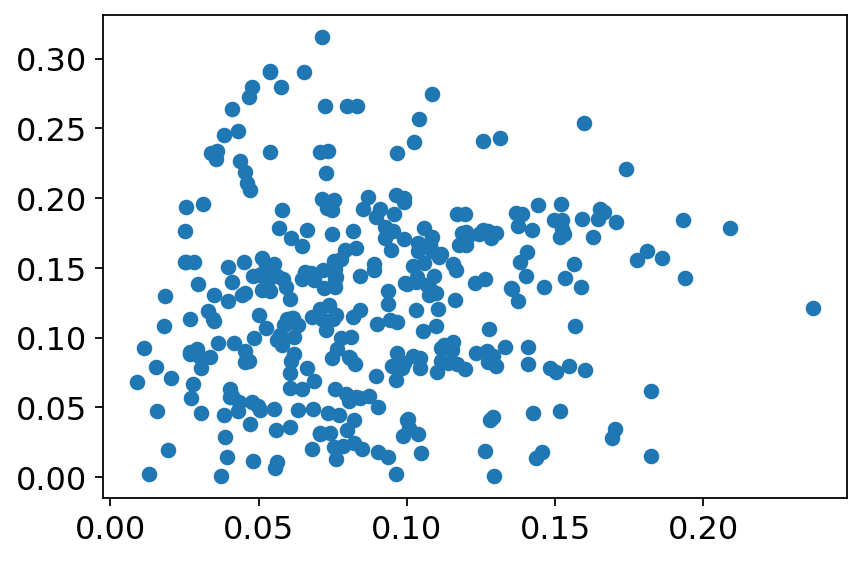

In [46]:
plt.scatter(MI_means, spearmans_abs)

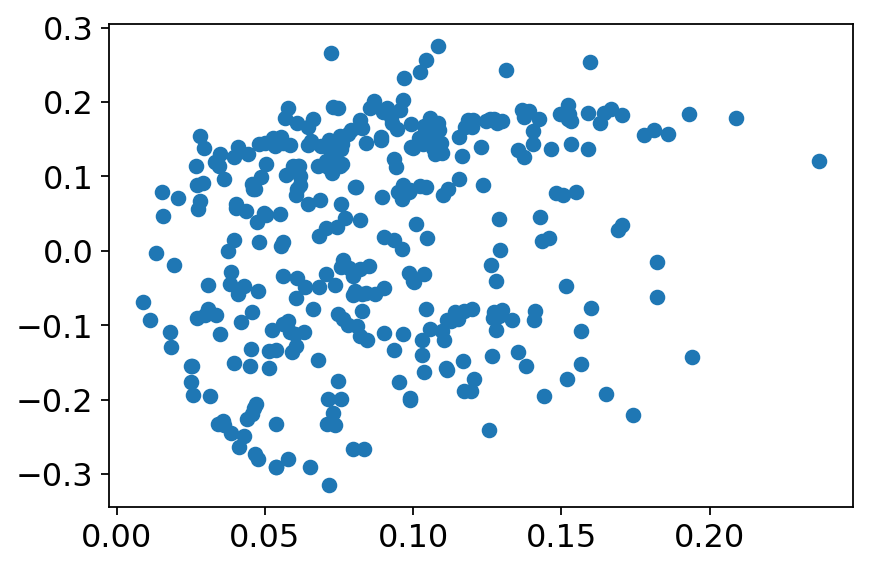

In [47]:
plt.scatter(MI_means, spearmans)

In [48]:
idx_MI_sorted = np.argsort(MI_means)[::-1]
idx_sp_sorted = np.argsort(spearmans_abs)[::-1]

Text(0, 0.5, 'mutual information [nat]')

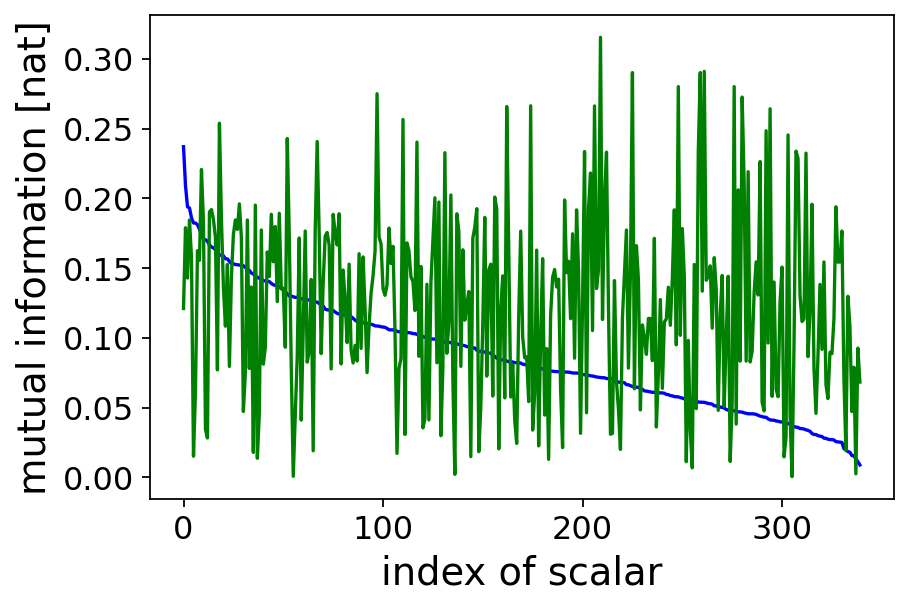

In [49]:
plt.plot(MI_means[idx_MI_sorted], color='blue')
plt.plot(spearmans_abs[idx_MI_sorted], color='green')

plt.xlabel("index of scalar")
plt.ylabel("mutual information [nat]")

Text(0, 0.5, 'mutual information [nat]')

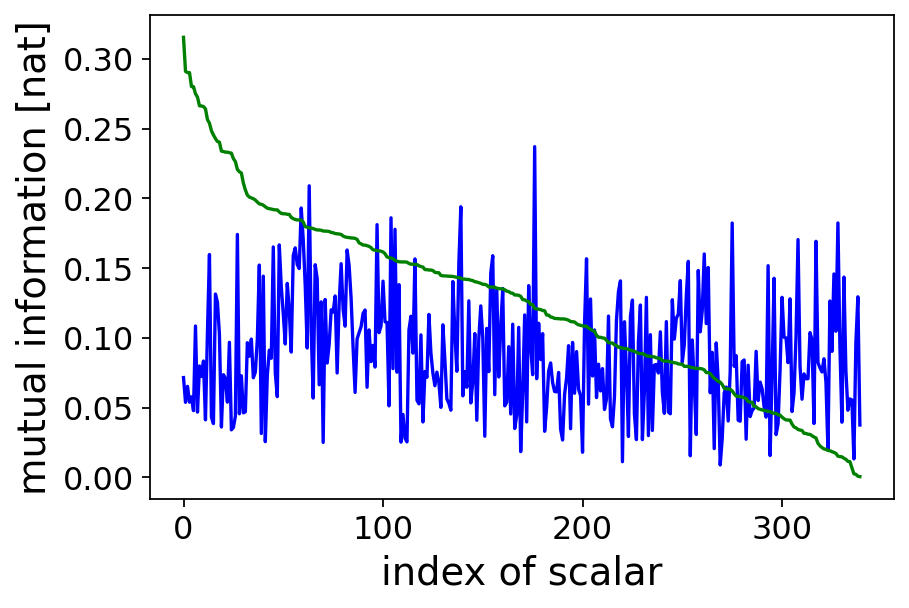

In [50]:
plt.plot(MI_means[idx_sp_sorted], color='blue')
plt.plot(spearmans_abs[idx_sp_sorted], color='green')

plt.xlabel("index of scalar")
plt.ylabel("mutual information [nat]")

In [51]:
for i in range(5):
    idx = idx_sorted[i]
    print(display(Markdown(scalar_name(s_arr_train[0,idx], scalar_featurizer.geo_feature_arr))))
    print(MI_means[idx])

$m_2$

None
0.14965650781822737


$\lambda_3\left(C^{vv}_1\right)$

None
0.11021014604383804


$\lambda_1\left(C^{vv}_2\right)$

None
0.075700792537886


$m_1$

None
0.0578343506994138


$m_0$

None
0.05765474356586557
